In [1]:
from mpl_toolkits.mplot3d import axes3d
from platform import python_version
from typing import Tuple
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

Project: Magnetic dipole simulation
Linter: flake8
Formatter: yapf

Simulate the field around a magnetic dipole according to the below link to formula.
https://wikimedia.org/api/rest_v1/media/math/render/svg/0991963d60a114ec41900b0eec04c944d03bb603

Notes:
mu_0 is the vacuum permeability and is defined as:
mu_0 = 4 * pi E -7 H/m
Henry per meter is the SI unit for magnetic field flux.
Thus, the constant term in the formula is 1E-7 H/m.

In [3]:
def simulate_from_origin(m: np.ndarray,
                         r: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """
    Compute magnetic field vectors at each position `r`
    derived from the magnetic dipole moment `m`.
    Tail of dipole moment is at origin.
    Args:
        m (np.ndarray): (3,) shape array representing magnetic dipole.
        r (np.ndarray): (n, 3) shape array representing points.
    Notes:
        n is the number of points.
    Returns:
        `r` with points near zero removed.
        (n, 3) shape array representing mangetic field vectors.
    """
    # (3,) [1, 2, 3] vector
    # (3, 1) [[1], [2], [3]] column vector (matrix)
    # (1, 3) [[1, 2, 3]] row vector (matrix)

    # filter rows containing any zeros in components
    # np.all([True, True, False]) == [True, True, False]
    # np.all([True, True, True]) == [True, True, True]
    # array = [1, 2, 3]
    # array[[True, False, True]] == [1, 3]
    # Truthy or Falsey
    # False == False
    # 0 == False
    # 2 == True
    r = r[np.all(r, axis=1)]

    # numerator on major term
    # (3 * (r @ m)) is a vector (x,)
    # (3 * (r @ m)) to (y, 3)
    prod = (3 * (r @ m))
    prod = np.expand_dims(prod, axis=1)
    prod = prod * r  # (n, 3) shape array

    # magnitude
    r_magnitude = np.linalg.norm(r, axis=1)
    r_magnitude = np.expand_dims(r_magnitude, axis=1)  # (n, 1) shape array

    # major term
    r5 = np.power(r_magnitude, 5)  # (n, 1) shape array
    major = prod / r5  # (n, 3) shape array

    # minor term
    r3 = np.power(r_magnitude, 3)  # (n, 1) shape array
    minor = m / r3

    # magnetic field
    # scalar -> (n, 3), elementwise multiply
    B = 1e-7 * (major - minor)

    # points -> magnetic field vectors
    return r, B

In [4]:
def superimpose_binary_op(m_1: np.ndarray, m_2: np.ndarray, r0_1: np.ndarray,
                          r0_2: np.ndarray,
                          r: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """
    Given two dipoles, calculate the superimposed magnetic field.
    Args:
        m_1 (np.ndarray): (3,) shape magnetic moment of the first dipole.
        m_2 (np.ndarray): (3,) shape magnetic moment of the second dipole.
        r0_1 (np.ndarray): (3,) shape position vector of first dipole.
        r0_2 (np.ndarray): (3,) shape position vector of the second dipole.
        r (np.ndarray): (n, 3) shape position vector of all points of interest in the field.
    Returns:
        `r` with points near zero removed.
        (n, 3) shape array representing magnetic field vectors.
    """
    # displacement vectors
    s_1 = r - r0_1
    s_2 = r - r0_2

    # magnetic fields based on displacement
    # instead of position
    r, B_1 = simulate_from_origin(m_1, s_1)
    r, B_2 = simulate_from_origin(m_2, s_2)

    return r, B_1 + B_2

In [5]:
def superimpose(r0: np.ndarray, m: np.ndarray,
                r: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """
    Superimpose magnetic field of m dipoles and associated magnetic fields.
    `m` > 1, for single simulation, see `simulate_from_origin`.
    Args:
        r0 (np.ndarray): (m, 3,) shape array of dipole locations.
        m (np.ndarray): (m, 3,) shape array of dipole moments.
        r (np.ndarray): (n, 3) shape position vector of all points of interest in the field.
    Notes:
        Generalizes `superimpose_binary_op`.
    Returns:
        `r` with points near zero removed.
        (n, 3) shape array representing magnetic field vectors.
    See:
        `superimpose_binary_op`
    """
    B = np.zeros(r.shape)
    m_zero = r_zero = np.zeros((3, ))
    for index in range(len(r0)):
        r, b = superimpose_binary_op(m_zero, m[index], r_zero, r0[index], r)
        B += b
    return r, B

In [6]:
def grid_points(*axis) -> np.ndarray:
    """
    Generates points to populate the space defined by `axis`.
    Args:
        axis (np.s_): Coordinate space axis represented by NumPy slice notation.
    Returns:
        (n, 3) shape array of all points in coordinate space.
    """
    return np.asarray([a.ravel() for a in np.mgrid[axis]]).T

In [9]:
# check versioning
print(f"NumPy {np.__version__}")
print(f"Python {python_version()}")

NumPy 1.18.1
Python 3.7.6


In [10]:
# simulation
axis = (np.s_[-1.8:2:.25], np.s_[-1.8:2:.25], np.s_[-1.8:2:.25])
r = grid_points(*axis)
m = np.array([0, 0, 1])
r, B = simulate_from_origin(m, r)
print(r)
print(B)

[[-1.8  -1.8  -1.8 ]
 [-1.8  -1.8  -1.55]
 [-1.8  -1.8  -1.3 ]
 ...
 [ 1.95  1.95  1.45]
 [ 1.95  1.95  1.7 ]
 [ 1.95  1.95  1.95]]
[[ 3.29989866e-09  3.29989866e-09  6.93889390e-25]
 [ 3.55948705e-09  3.55948705e-09 -7.12322678e-10]
 [ 3.67944208e-09  3.67944208e-09 -1.62482485e-09]
 ...
 [ 2.88905208e-09  2.88905208e-09 -1.15800496e-09]
 [ 2.78707516e-09  2.78707516e-09 -5.11454214e-10]
 [ 2.59545966e-09  2.59545966e-09  0.00000000e+00]]


In [11]:
# superimpose binary
m_1 = np.array([0, 0, 1])
m_2 = np.array([2, 0, 1])
r0_1 = np.array([0, 2, 0])
r0_2 = np.array([2, 2, 0])
r = grid_points(*axis)
r, B = superimpose_binary_op(m_1, m_2, r0_1, r0_2, r)
print(r)
print(B)

[[-3.8  -3.8  -1.8 ]
 [-3.8  -3.8  -1.55]
 [-3.8  -3.8  -1.3 ]
 ...
 [-0.05 -0.05  1.45]
 [-0.05 -0.05  1.7 ]
 [-0.05 -0.05  1.95]]
[[ 1.21962336e-09  2.85782682e-09 -2.40725946e-10]
 [ 1.22580153e-09  2.88344761e-09 -5.06550114e-10]
 [ 1.20545800e-09  2.86109334e-09 -7.85864385e-10]
 ...
 [-5.85102382e-08 -3.39697143e-09  5.88625896e-08]
 [-3.37110449e-08 -1.90289097e-09  3.86242034e-08]
 [-2.07543102e-08 -1.16422719e-09  2.71791994e-08]]


In [12]:
# superimpose general
m = np.array([[0, 0, 1], [0, 1, 1], [1, 0, 0]])
r0 = np.array([[1, 2, 1], [0, 2, 1], [0, 3, 3]])
r = grid_points(*axis)
r, B = superimpose(m, r0, r)
print(r)
print(B)

[[-2.8  -2.8  -3.8 ]
 [-2.8  -2.8  -3.55]
 [-2.8  -2.8  -3.3 ]
 ...
 [ 0.95  0.95 -0.55]
 [ 0.95  0.95 -0.3 ]
 [ 0.95  0.95 -0.05]]
[[ 8.74416450e-09  4.38972832e-09  1.22310691e-08]
 [ 1.05032808e-08  5.64131021e-09  1.33541024e-08]
 [ 1.26207462e-08  7.19179801e-09  1.44139610e-08]
 ...
 [ 8.41691808e-08 -4.35358500e-08 -1.41247101e-07]
 [ 1.47224590e-07 -7.01578535e-10 -1.59852949e-07]
 [ 2.12513702e-07  5.39057719e-08 -1.37891872e-07]]


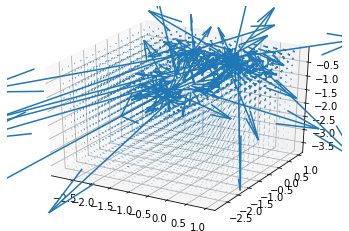

In [15]:
# plot
x, y, z = r.T[0], r.T[1], r.T[2]
u, v, w = B.T[0], B.T[1], B.T[2]
fig = plt.figure()
plot = fig.gca(projection='3d')
plot.quiver(x, y, z, u, v, w, length=2e5)


np.clip is necessary to normalize some magnetic field vectors for even size distribution
B field does not only take into account direction with uniform vector length, but also magnitude